# GamesExploration

import steam.GetPlayerSummaries.json file and steam.GetOwnedGames.json

In [2]:
import json
import pprint
from pymongo import MongoClient
import pandas as pd

client = MongoClient()
db = client.steam
db.collection_names(include_system_collections=False)

['GetOwnedGames_1000buckets_50_09270334',
 'GetPlayerSummaries',
 'GetPlayerSummaries09231725',
 'GetOwnedGames09241524',
 'GetOwnedGames100000',
 'GetPlayerSummaries09240049',
 'GetOwnedGames_90000_09251948',
 'GetOwnedGames_90000_09252023',
 'GetOwnedGames09231725',
 'GetPlayerSummaries_1000buckets_50_09270334',
 'GetPlayerSummaries09241524',
 'GetOwnedGames_1000buckets_50_09262001',
 'GetPlayerSummaries1000B_5000perB',
 'GetPlayerSummaries_90000_09251948',
 'GetPlayerSummaries_90000_09252023',
 'GetOwnedGames09250948',
 'GetOwnedGames',
 'GetPlayerSummaries_1000buckets_50_09262001',
 'GetOwnedGames09240049',
 'GetPlayerSummaries09250948']

In [3]:
playerSum = db.GetPlayerSummaries_90000_09251948
ownedGames = db.GetOwnedGames
playerTotal = 45709
gamesTotal = 412158
init = 76561197960265728
end = 76561198422588320

In [154]:
# test loading and parsing the games.json
text= '[{"720000":{"data":[],"success":true}},{"720110":{"data":[],"success":true}},{"720140":{"data":[],"success":true}},{"720280":{"data":[],"success":true}},{"720320":{"data":[],"success":true}},{"720340":{"data":{"price_overview":{"currency":"USD","initial":99,"final":59,"discount_percent":40}},"success":true}},{"720460":{"data":[],"success":true}},{"720470":{"data":[],"success":true}},{"720900":{"data":{"price_overview":{"currency":"USD","initial":499,"final":499,"discount_percent":0}},"success":true}}]'
# app Id: list(entry.keys())[0]
j = json.loads(text)

for entry in j:
    appId = list(entry.keys())[0]
    price = 0
    print(entry[appId])
    if(entry.get(appId) and entry[appId]['success'] == True and entry[appId]['data']):
        price = entry[appId]['data']['price_overview']['final']/100
        if (price != 0):
            print(appId,price)
    

{'data': [], 'success': True}
{'data': [], 'success': True}
{'data': [], 'success': True}
{'data': [], 'success': True}
{'data': [], 'success': True}
{'data': {'price_overview': {'currency': 'USD', 'initial': 99, 'final': 59, 'discount_percent': 40}}, 'success': True}
720340 0.59
{'data': [], 'success': True}
{'data': [], 'success': True}
{'data': {'price_overview': {'currency': 'USD', 'initial': 499, 'final': 499, 'discount_percent': 0}}, 'success': True}
720900 4.99


In [159]:
with open('game.json', 'r') as json_file:
    games_json = json.load(json_file)

appid_prices = []
for entry in games_json:
    appId = list(entry.keys())[0]
     # default in case it is free game(or deleted game)
    price = 0
    if(entry.get(appId) and entry[appId]['success'] == True and entry[appId]['data']):
        price = entry[appId]['data']['price_overview']['final']/100
    appid_prices.append([int(appId), price])
    
gameprices = pd.DataFrame(appid_prices, columns=('appid', 'price'))

In [142]:
len(gameprices)

48213

## Average playtime by appid (game)

In [114]:
b = ownedGames.aggregate([{"$unwind": "$response"}, 
   #                       {"$match":{"$response.game_count": {"gt": 0}} }, 
                          {"$unwind": "$response.games"},
                          {"$group":{
                             "_id":{
                                 "appid": "$response.games.appid",
                                 "name": "$response.games.name"
                             },
                             "numPlayer":{"$sum": 1},
                             "totalTime": {"$sum": "$response.games.playtime_forever"}
                          }}
                         ])

In [115]:
l=[]
for line in b:
    l.append([int(line['_id']['appid']), line['_id']['name'], line['numPlayer'], line['totalTime']])

gameData = pd.DataFrame(l, columns=('appid', 'name', 'numPlayer', 'totalTime'))
gameData.head()

,appid,name,numPlayer,totalTime
0,34650,Massive Assault Network 2,1,2
1,34630,Massive Assault,1,2390
2,490380,Flight 787 - Advanced,1,256
3,532950,Hoyle Official Casino Games,1,208
4,442890,Magic Potion Explorer,1,81


In [116]:
len(gameData)

15930

In [38]:
sorted_by_numPlayers=gameData.sort_values(by = ['numPlayer'], ascending=False)
sorted_by_numPlayers.head(10)


,appid,name,numPlayer,totalTime
15867,205790,Dota 2 Test,62084,324132
15643,730,Counter-Strike: Global Offensive,30640,531305447
15841,304930,Unturned,30282,29320246
15739,230410,Warframe,16657,46352040
14746,223530,Left 4 Dead 2 Beta,15817,42544
14753,550,Left 4 Dead 2,15817,32392806
14893,240,Counter-Strike: Source,14966,91012667
15598,340,Half-Life 2: Lost Coast,14914,159113
14991,218620,PAYDAY 2,14803,31955144
15358,227940,Heroes & Generals,14068,6822289


In [170]:
result = pd.merge(sorted_by_numPlayers, gameprices,on='appid', how='left')
#games with price zero are either free or deleted from steam store. 
#filter them out
result=result[result['price'] != 0]
result.head(10)

,appid,name,numPlayer,totalTime,price
1,730,Counter-Strike: Global Offensive,30640,531305447,14.99
5,550,Left 4 Dead 2,15817,32392806,19.99
6,240,Counter-Strike: Source,14966,91012667,19.99
10,320,Half-Life 2: Deathmatch,13995,1787667,4.99
11,4000,Garry's Mod,12656,69735162,9.99
14,10,Counter-Strike,12264,94744623,9.99
16,578080,PLAYERUNKNOWN'S BATTLEGROUNDS,11586,62882865,29.99
18,72850,The Elder Scrolls V: Skyrim,10486,70915354,19.99
19,100,Counter-Strike: Condition Zero Deleted Scenes,10263,339387,9.99
20,80,Counter-Strike: Condition Zero,10263,8710285,9.99


In [171]:
result['avgTime(h)PerP'] = result['totalTime']/result['numPlayer']/float(60)
result.head(10)

,appid,name,numPlayer,totalTime,price,avgTime(h)PerP
1,730,Counter-Strike: Global Offensive,30640,531305447,14.99,289.004268
5,550,Left 4 Dead 2,15817,32392806,19.99,34.132901
6,240,Counter-Strike: Source,14966,91012667,19.99,101.354923
10,320,Half-Life 2: Deathmatch,13995,1787667,4.99,2.128935
11,4000,Garry's Mod,12656,69735162,9.99,91.834126
14,10,Counter-Strike,12264,94744623,9.99,128.757098
16,578080,PLAYERUNKNOWN'S BATTLEGROUNDS,11586,62882865,29.99,90.458118
18,72850,The Elder Scrolls V: Skyrim,10486,70915354,19.99,112.714340
19,100,Counter-Strike: Condition Zero Deleted Scenes,10263,339387,9.99,0.551150
20,80,Counter-Strike: Condition Zero,10263,8710285,9.99,14.145125


In [172]:
result['avgCostPerHourPerPerson'] = result['price']/result['avgTime(h)PerP']
result.head(10)

,appid,name,numPlayer,totalTime,price,avgTime(h)PerP,avgCostPerHourPerPerson
1,730,Counter-Strike: Global Offensive,30640,531305447,14.99,289.004268,0.051868
5,550,Left 4 Dead 2,15817,32392806,19.99,34.132901,0.585652
6,240,Counter-Strike: Source,14966,91012667,19.99,101.354923,0.197228
10,320,Half-Life 2: Deathmatch,13995,1787667,4.99,2.128935,2.343895
11,4000,Garry's Mod,12656,69735162,9.99,91.834126,0.108783
14,10,Counter-Strike,12264,94744623,9.99,128.757098,0.077588
16,578080,PLAYERUNKNOWN'S BATTLEGROUNDS,11586,62882865,29.99,90.458118,0.331535
18,72850,The Elder Scrolls V: Skyrim,10486,70915354,19.99,112.714340,0.177351
19,100,Counter-Strike: Condition Zero Deleted Scenes,10263,339387,9.99,0.551150,18.125745
20,80,Counter-Strike: Condition Zero,10263,8710285,9.99,14.145125,0.706250


In [174]:
result.to_csv(path_or_buf="gamesTable.csv")

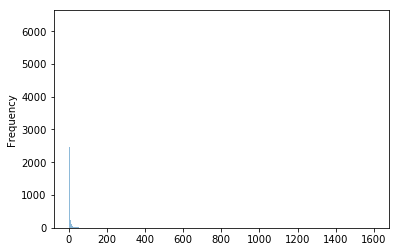

The maximu


appid                                               502410
name              Airport Fire Department - The Simulation
numPlayer                                                1
totalTime                                            95822
avgTime(h)PerP                                     1597.03
Name: 8523, dtype: object

In [31]:
import matplotlib.pyplot as plt
avgTime = gameData['avgTime(h)PerP']
avgTime.plot.hist(alpha=0.5, bins=1000)
plt.show()

print('The maximu')
gameData.loc[gameData['avgTime(h)PerP'].argmax()]